In [2]:
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from tqdm import tqdm
from mendeleev.fetch import fetch_table
from seaborn_fig2grid import SeabornFig2Grid
import matplotlib.gridspec as gridspec
import pickle
import matplotlib

sns.set_style('whitegrid')
%matplotlib inline

sys.path.append(str(Path().resolve().parent))
Path("plots/gfn_samples").mkdir(parents=True, exist_ok=True)

sns.set_palette(sns.color_palette("colorblind", 4))

output_path = Path("plots/gfn_samples_v2")
output_path.mkdir(parents=True, exist_ok=True)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [3]:
def denorm_l(l, min_l=0.9, max_l=100):
    return l * (max_l - min_l) + min_l

def denorm_a(a, min_a=50, max_a=150):
    return a * (max_a - min_a) + min_a

def norm_l(l, min_l=0.9, max_l=100):
    return (l - min_l) / (max_l - min_l)

def norm_a(a, min_a=50, max_a=150):
    return (a - min_a) / (max_a - min_a)

def make_row(d, sg_idx, nz, els, denorm=False):
    s = {}
    for k in range(nz):
        s[els[k]] = d[k + 1]
    s["sg"] = d[sg_idx]
    s["a"] = d[sg_idx + 1]
    s["b"] = d[sg_idx + 2]
    s["c"] = d[sg_idx + 3]
    s["alpha"] = d[sg_idx + 4]
    s["beta"] = d[sg_idx + 5]
    s["gamma"] = d[sg_idx + 6]
    if denorm:
        for k in ["a", "b", "c"]:
            s[k] = denorm_l(s[k])
        for k in ["alpha", "beta", "gamma"]:
            s[k] = denorm_a(s[k])
    return s

In [4]:
v12path = "/network/scratch/s/schmidtv/crystals-proxys/data/ai4mat-plots-data/matbench_val_12_SGinter_states_energy.pkl"
v12normed_path = "/network/scratch/s/schmidtv/crystals-proxys/data/ai4mat-plots-data/matbench_normed_l0.9-100_a50-150_val_12_SGinter_states_energy.pkl"
samples_path = "/network/scratch/s/schmidtv/crystals-proxys/data/ai4mat-plots-data/gfn_samples_v2/samples_all.pkl"
train_df_path = "/network/scratch/s/schmidtv/crystals-proxys/data/materials_dataset_v3/data/matbench_mp_e_form/train_data.csv"
val_df_path = "/network/scratch/s/schmidtv/crystals-proxys/data/materials_dataset_v3/data/matbench_mp_e_form/val_data.csv"

with open(v12path, "rb") as f:
    v12 = pickle.load(f)
with open(v12normed_path, "rb") as f:
    data_normed = pickle.load(f)
with open(samples_path, "rb") as f:
    samples = pickle.load(f)
t12df = pd.read_csv(train_df_path)
full_val_df = pd.read_csv(val_df_path)
full_train_df = t12df.copy()


In [5]:
zs = np.array([1, 3, 6, 7, 8, 9, 12, 14, 15, 16, 17, 26])
table = fetch_table("elements")["symbol"]
els = table.iloc[zs-1].values
nz = len(zs)
sg_idx = nz + 3
h_idx = t12df.columns.to_list().index("H")
e_idx = t12df.columns.to_list().index("Eform")
non_zero_els = full_train_df[full_train_df.columns[h_idx:e_idx]].sum(axis=0) > 0
non_zero_els = non_zero_els.index[non_zero_els]

In [6]:
v12df = []
for i, d in enumerate(v12["x"]):
    row = make_row(d, sg_idx, nz, els, denorm=False)
    row["energy"] = v12["energy"][i]
    v12df.append(row)
v12df = pd.DataFrame(v12df)

sdf = []
for i, d in enumerate(samples["Crystal-GFlownet"]["x"]):
    row = make_row(d, sg_idx, nz, els, denorm=True)
    row["energy"] = samples["Crystal-GFlownet"]["energy"][i]
    sdf.append(row)
sdf = pd.DataFrame(sdf)

In [7]:
non_allowed_els = [c for c in t12df.columns[h_idx:e_idx] if c not in els]
keep_comp = t12df[non_allowed_els].sum(axis=1) == 0
t12df = t12df.iloc[keep_comp.values]


In [8]:
assert len(t12df) == 2987

In [9]:
allowed_sgs = set([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 25, 26, 29, 30, 31, 33, 36, 38, 40, 41, 43, 44, 46, 47, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 69, 70, 71, 72, 74, 82, 84, 85, 86, 87, 88, 92, 99, 102, 107, 113, 114, 121, 122, 123, 126, 129, 131, 136, 137, 138, 139, 140, 141, 146, 147, 148, 150, 155, 156, 160, 161, 162, 163, 164, 166, 167, 176, 181, 185, 186, 187, 189, 192, 194, 198, 199, 205, 206, 216, 217, 220, 221, 224, 225, 227, 229, 230])

t12df = t12df[t12df["Space Group"].isin(allowed_sgs)]
t12df["sg"] = t12df["Space Group"]
t12df["energy"] = t12df["Eform"]
t12df = t12df[sdf.columns]

In [14]:
t12df.columns

Index(['H', 'Li', 'C', 'N', 'O', 'F', 'Mg', 'Si', 'P', 'S', 'Cl', 'Fe', 'sg',
       'a', 'b', 'c', 'alpha', 'beta', 'gamma', 'energy', 'source'],
      dtype='object')

In [10]:
print(f"Number of samples: {len(sdf)}")
print(f"Number of validation samples: {len(v12df)}")
print(f"Number of training samples: {len(t12df)}")

Number of samples: 10000
Number of validation samples: 1118
Number of training samples: 2861


In [11]:
sdf["source"] = "Crystal-GFlownet"
v12df["source"] = "MatBench Val"
t12df["source"] = "MatBench Train"
df = pd.concat([sdf, v12df, t12df])

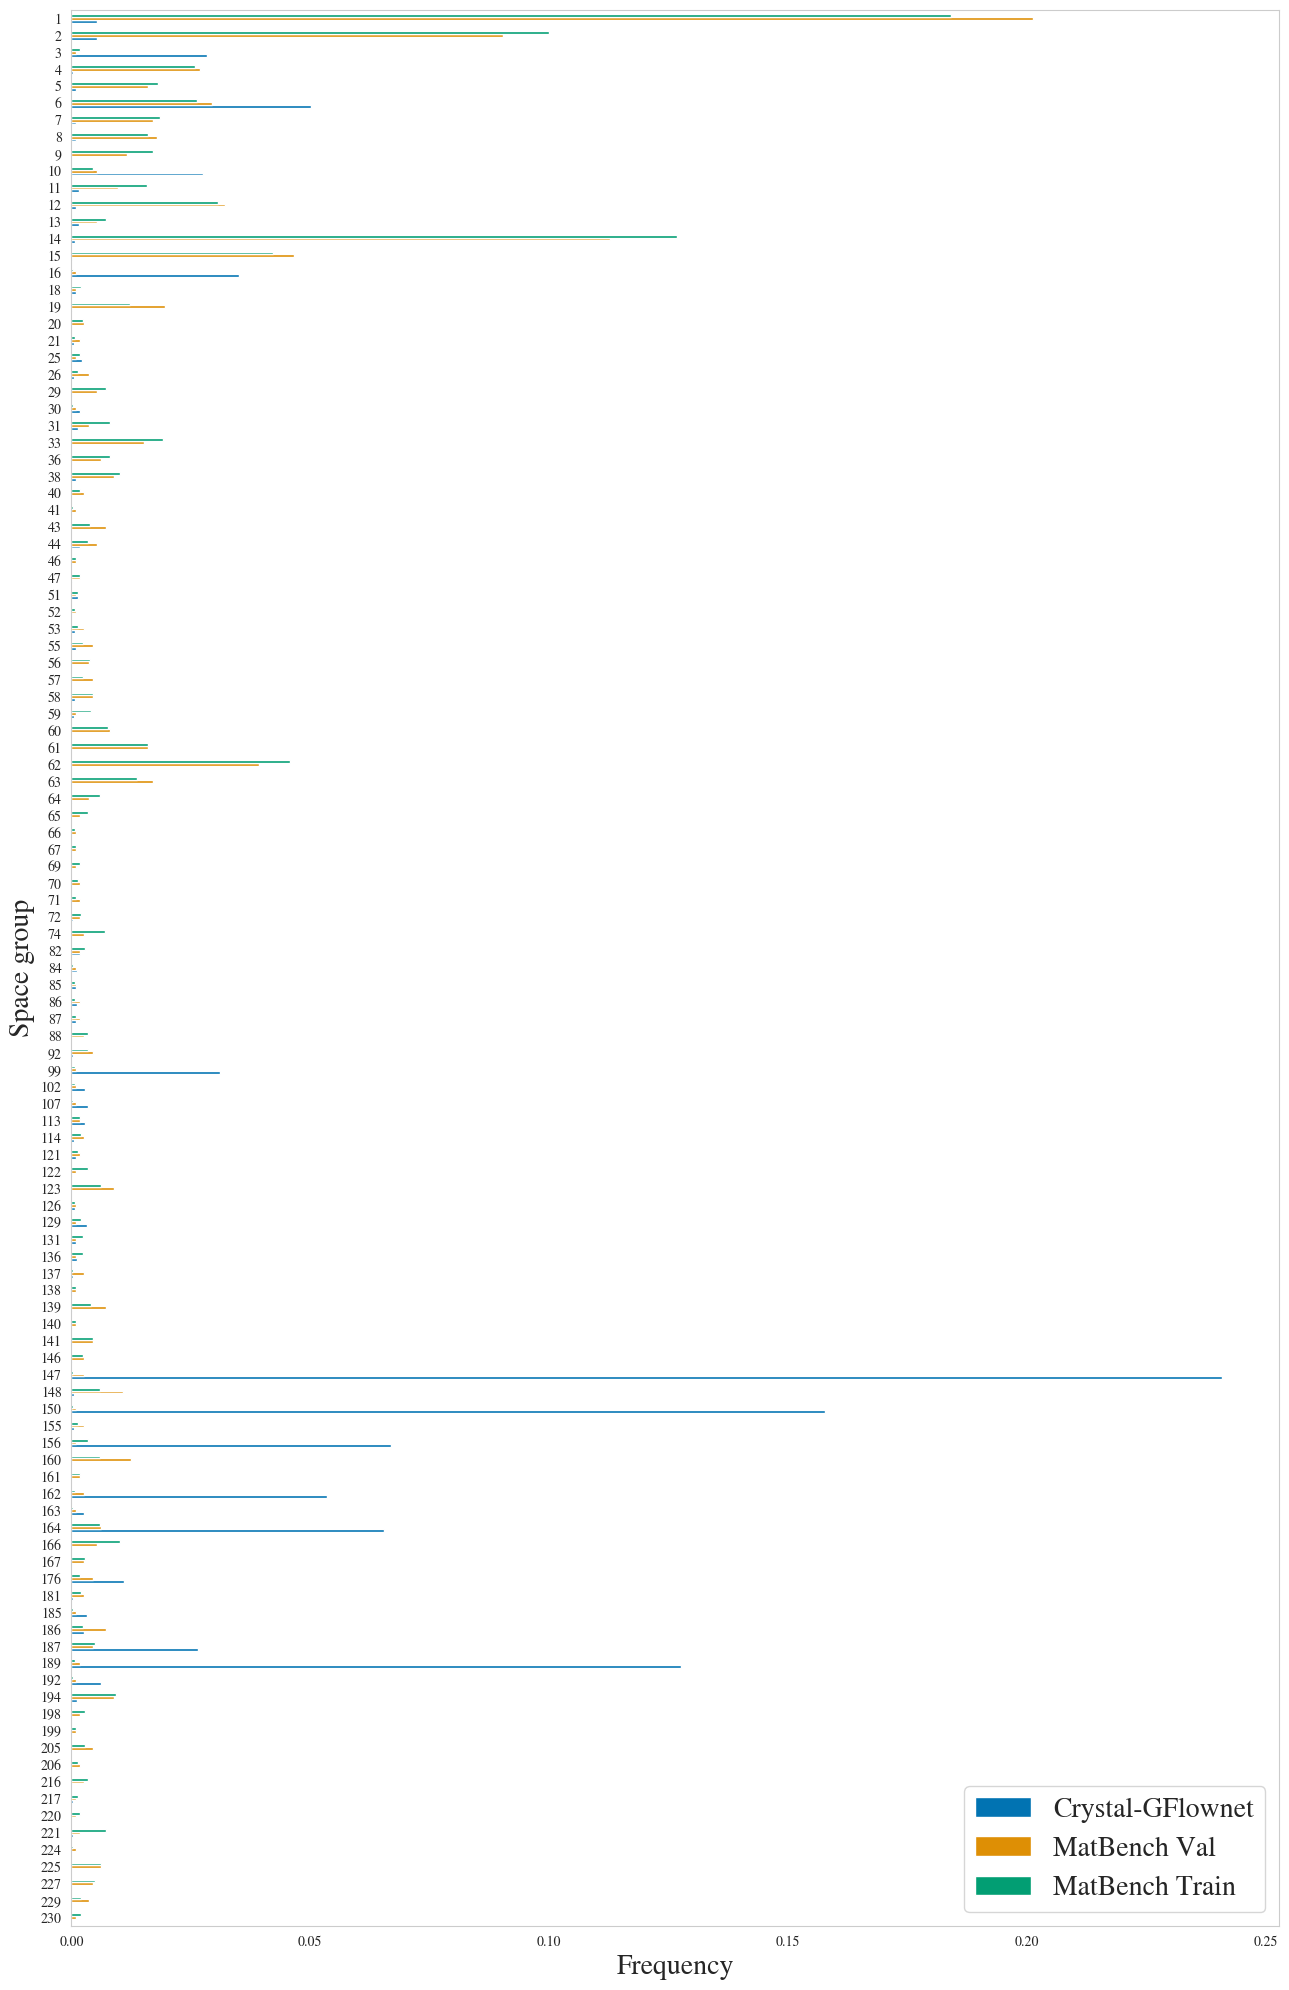

In [10]:
# plot the bar plot of the space group distribution
# in the data versus the samples
# counts should be normalized by the total number of elements per data source

sdf_sg_counts = sdf["sg"].value_counts().sort_index()
sdf_sg_counts = sdf_sg_counts / sdf_sg_counts.sum()
valdf_sg_counts = v12df["sg"].value_counts().sort_index()
valdf_sg_counts = valdf_sg_counts / valdf_sg_counts.sum()
traindf_sg_counts = t12df["sg"].value_counts().sort_index()
traindf_sg_counts = traindf_sg_counts / traindf_sg_counts.sum()

sg_counts = pd.concat([sdf_sg_counts, valdf_sg_counts, traindf_sg_counts], axis=1).sort_index(ascending=False)
sg_counts.columns = ["Crystal-GFlownet", "MatBench Val", "MatBench Train"]
sg_counts = sg_counts.fillna(0)

fig, ax = plt.subplots(figsize=(13, 20))
sg_counts.plot.barh(ax=ax)
ax.set_xlabel("Frequency", fontsize=20)
ax.set_ylabel("Space group", fontsize=20)
fig.tight_layout()
ax.grid(False)
ax.legend(fontsize=20, loc="lower right")
fig.savefig(output_path / "sg_counts.pdf")


In [11]:
sg_counts

,Crystal-GFlownet,MatBench Val,MatBench Train
sg,,,
230,0.0000,0.000894,0.002097
229,0.0000,0.003578,0.002097
227,0.0000,0.004472,0.004893
225,0.0000,0.006261,0.006292
224,0.0000,0.000894,0.000350
...,...,...,...
5,0.0010,0.016100,0.018175
4,0.0004,0.026834,0.025865
3,0.0283,0.000894,0.001748


In [12]:
print(sdf_sg_counts.index.to_list())
print(valdf_sg_counts.index.to_list())
print(traindf_sg_counts.index.to_list())

[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 18, 19, 21, 25, 26, 29, 30, 31, 36, 38, 41, 44, 47, 51, 53, 55, 56, 58, 59, 62, 64, 72, 82, 84, 85, 86, 87, 92, 99, 102, 107, 113, 114, 121, 122, 126, 129, 131, 136, 137, 138, 139, 140, 146, 147, 148, 150, 155, 156, 160, 162, 163, 164, 166, 176, 181, 185, 186, 187, 189, 192, 194, 198, 217, 221]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 25, 26, 29, 30, 31, 33, 36, 38, 40, 41, 43, 44, 46, 47, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 69, 70, 71, 72, 74, 82, 84, 85, 86, 87, 88, 92, 99, 102, 107, 113, 114, 121, 122, 123, 126, 129, 131, 136, 137, 138, 139, 140, 141, 146, 147, 148, 150, 155, 156, 160, 161, 162, 163, 164, 166, 167, 176, 181, 185, 186, 187, 189, 192, 194, 198, 199, 205, 206, 216, 217, 220, 221, 224, 225, 227, 229, 230]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 25, 26, 29, 30, 31, 33, 36, 38, 40, 41, 43, 44, 46, 47, 51, 52, 53, 55, 56, 57, 58, 5

In [13]:
print(sg_counts.index.to_list())
sg_counts

[230, 229, 227, 225, 224, 221, 220, 217, 216, 206, 205, 199, 198, 194, 192, 189, 187, 186, 185, 181, 176, 167, 166, 164, 163, 162, 161, 160, 156, 155, 150, 148, 147, 146, 141, 140, 139, 138, 137, 136, 131, 129, 126, 123, 122, 121, 114, 113, 107, 102, 99, 92, 88, 87, 86, 85, 84, 82, 74, 72, 71, 70, 69, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 53, 52, 51, 47, 46, 44, 43, 41, 40, 38, 36, 33, 31, 30, 29, 26, 25, 21, 20, 19, 18, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]


,Crystal-GFlownet,MatBench Val,MatBench Train
sg,,,
230,0.0000,0.000894,0.002097
229,0.0000,0.003578,0.002097
227,0.0000,0.004472,0.004893
225,0.0000,0.006261,0.006292
224,0.0000,0.000894,0.000350
...,...,...,...
5,0.0010,0.016100,0.018175
4,0.0004,0.026834,0.025865
3,0.0283,0.000894,0.001748


In [14]:
__a = pd.concat([sdf_sg_counts, valdf_sg_counts, traindf_sg_counts], axis=1, sort=True, join="outer", ignore_index=True).fillna(0)
print(__a.index.to_list())
__a

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 25, 26, 29, 30, 31, 33, 36, 38, 40, 41, 43, 44, 46, 47, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 69, 70, 71, 72, 74, 82, 84, 85, 86, 87, 88, 92, 99, 102, 107, 113, 114, 121, 122, 123, 126, 129, 131, 136, 137, 138, 139, 140, 141, 146, 147, 148, 150, 155, 156, 160, 161, 162, 163, 164, 166, 167, 176, 181, 185, 186, 187, 189, 192, 194, 198, 199, 205, 206, 216, 217, 220, 221, 224, 225, 227, 229, 230]


,0,1,2
sg,,,
1,0.0054,0.201252,0.184201
2,0.0054,0.090340,0.099965
3,0.0283,0.000894,0.001748
4,0.0004,0.026834,0.025865
5,0.0010,0.016100,0.018175
...,...,...,...
224,0.0000,0.000894,0.000350
225,0.0000,0.006261,0.006292
227,0.0000,0.004472,0.004893


In [15]:
empty_train_sg = set(allowed_sgs) - set(t12df["sg"].unique())
empty_val_sg = set(allowed_sgs) - set(v12df["sg"].unique())
empty_sdf_sg = set(allowed_sgs) - set(sdf["sg"].unique())

print(f"Empty space groups in training data: {empty_train_sg} (n={len(empty_train_sg)})")
print(f"Empty space groups in validation data: {empty_val_sg} (n={len(empty_val_sg)})")
print(f"Empty space groups in samples: {empty_sdf_sg} (n={len(empty_sdf_sg)})")

Empty space groups in training data: set() (n=0)
Empty space groups in validation data: set() (n=0)
Empty space groups in samples: {9, 141, 20, 33, 161, 167, 40, 43, 46, 52, 57, 60, 61, 63, 65, 66, 67, 69, 70, 71, 199, 74, 205, 206, 88, 216, 220, 224, 225, 227, 229, 230, 123} (n=33)


/tmp/ipykernel_942/2791781655.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{x:.2f}" for x in ax.get_yticks()], fontsize=14)


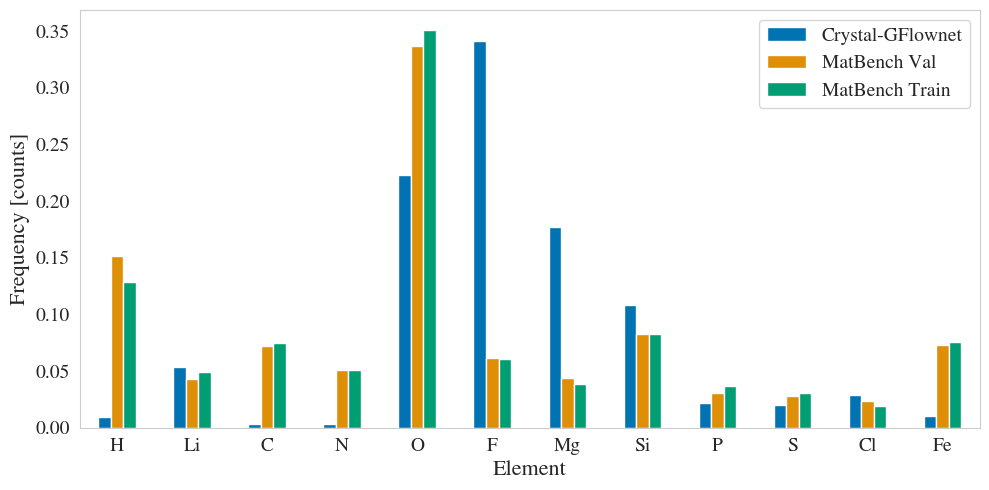

In [16]:
# plot the bar plot of the element distribution
# in the data versus the samples
# counts should be normalized by the total number of elements per data source

sdf_el_counts = sdf[els].sum(axis=0)
sdf_el_counts = sdf_el_counts / sdf_el_counts.sum()
valdf_el_counts = v12df[els].sum(axis=0)
valdf_el_counts = valdf_el_counts / valdf_el_counts.sum()
traindf_el_counts = t12df[els].sum(axis=0)
traindf_el_counts = traindf_el_counts / traindf_el_counts.sum()

el_counts = pd.concat([sdf_el_counts, valdf_el_counts, traindf_el_counts], axis=1)
el_counts.columns = ["Crystal-GFlownet", "MatBench Val", "MatBench Train"]
el_counts = el_counts.fillna(0)

fig, ax = plt.subplots(figsize=(10, 5))
el_counts.plot.bar(ax=ax)
ax.legend(fontsize=14, loc="upper right")
ax.set_ylabel("Frequency [counts]", fontsize=16)
ax.set_xlabel("Element", fontsize=16)
ax.set_xticklabels(el_counts.index, rotation=360, fontsize=14)
ax.set_yticklabels([f"{x:.2f}" for x in ax.get_yticks()], fontsize=14)
fig.tight_layout()
ax.grid(False)
fig.savefig(output_path / "el_counts_total.pdf")

/tmp/ipykernel_942/1441341996.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{x:.2f}" for x in ax.get_yticks()], fontsize=14)


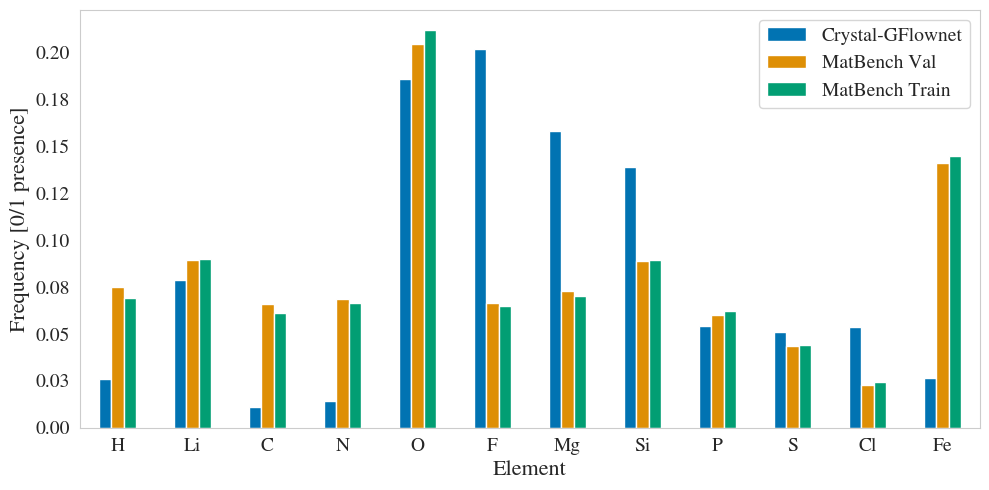

In [18]:
# plot the bar plot of the element distribution
# in the data versus the samples
# counts should be normalized by the total number of elements per data source

sdf_el_counts = (sdf[els] > 0).sum(axis=0)
sdf_el_counts = sdf_el_counts / sdf_el_counts.sum()
valdf_el_counts = (v12df[els] > 0).sum(axis=0)
valdf_el_counts = valdf_el_counts / valdf_el_counts.sum()
traindf_el_counts = (t12df[els] > 0).sum(axis=0)
traindf_el_counts = traindf_el_counts / traindf_el_counts.sum()

el_counts = pd.concat([sdf_el_counts, valdf_el_counts, traindf_el_counts], axis=1)
el_counts.columns = ["Crystal-GFlownet", "MatBench Val", "MatBench Train"]
el_counts = el_counts.fillna(0)

fig, ax = plt.subplots(figsize=(10, 5))
el_counts.plot.bar(ax=ax)
ax.set_ylabel("Frequency [0/1 presence]", fontsize=16)
ax.set_xlabel("Element", fontsize=16)
ax.legend(fontsize=14, loc="upper right")
ax.set_xticklabels(el_counts.index, rotation=360, fontsize=14)
ax.set_yticklabels([f"{x:.2f}" for x in ax.get_yticks()], fontsize=14)
fig.tight_layout()
ax.grid(False)
fig.savefig(output_path / "el_counts_binary.pdf")

In [19]:
sdf[els]

,H,Li,C,N,O,F,Mg,Si,P,S,Cl,Fe
0,0,6,0,0,0,14,5,0,0,0,0,0
1,0,0,0,0,16,14,16,0,0,0,0,2
2,0,5,0,0,6,15,0,5,0,0,0,0
3,0,8,0,0,0,16,12,0,0,0,4,0
4,0,0,0,0,6,14,0,8,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,0,0,0,9,15,15,0,4,0,0,0
9996,0,9,0,0,13,11,3,0,1,0,0,0
9997,0,7,0,0,8,9,0,4,1,0,0,0
9998,0,4,0,0,10,15,11,9,0,0,0,0


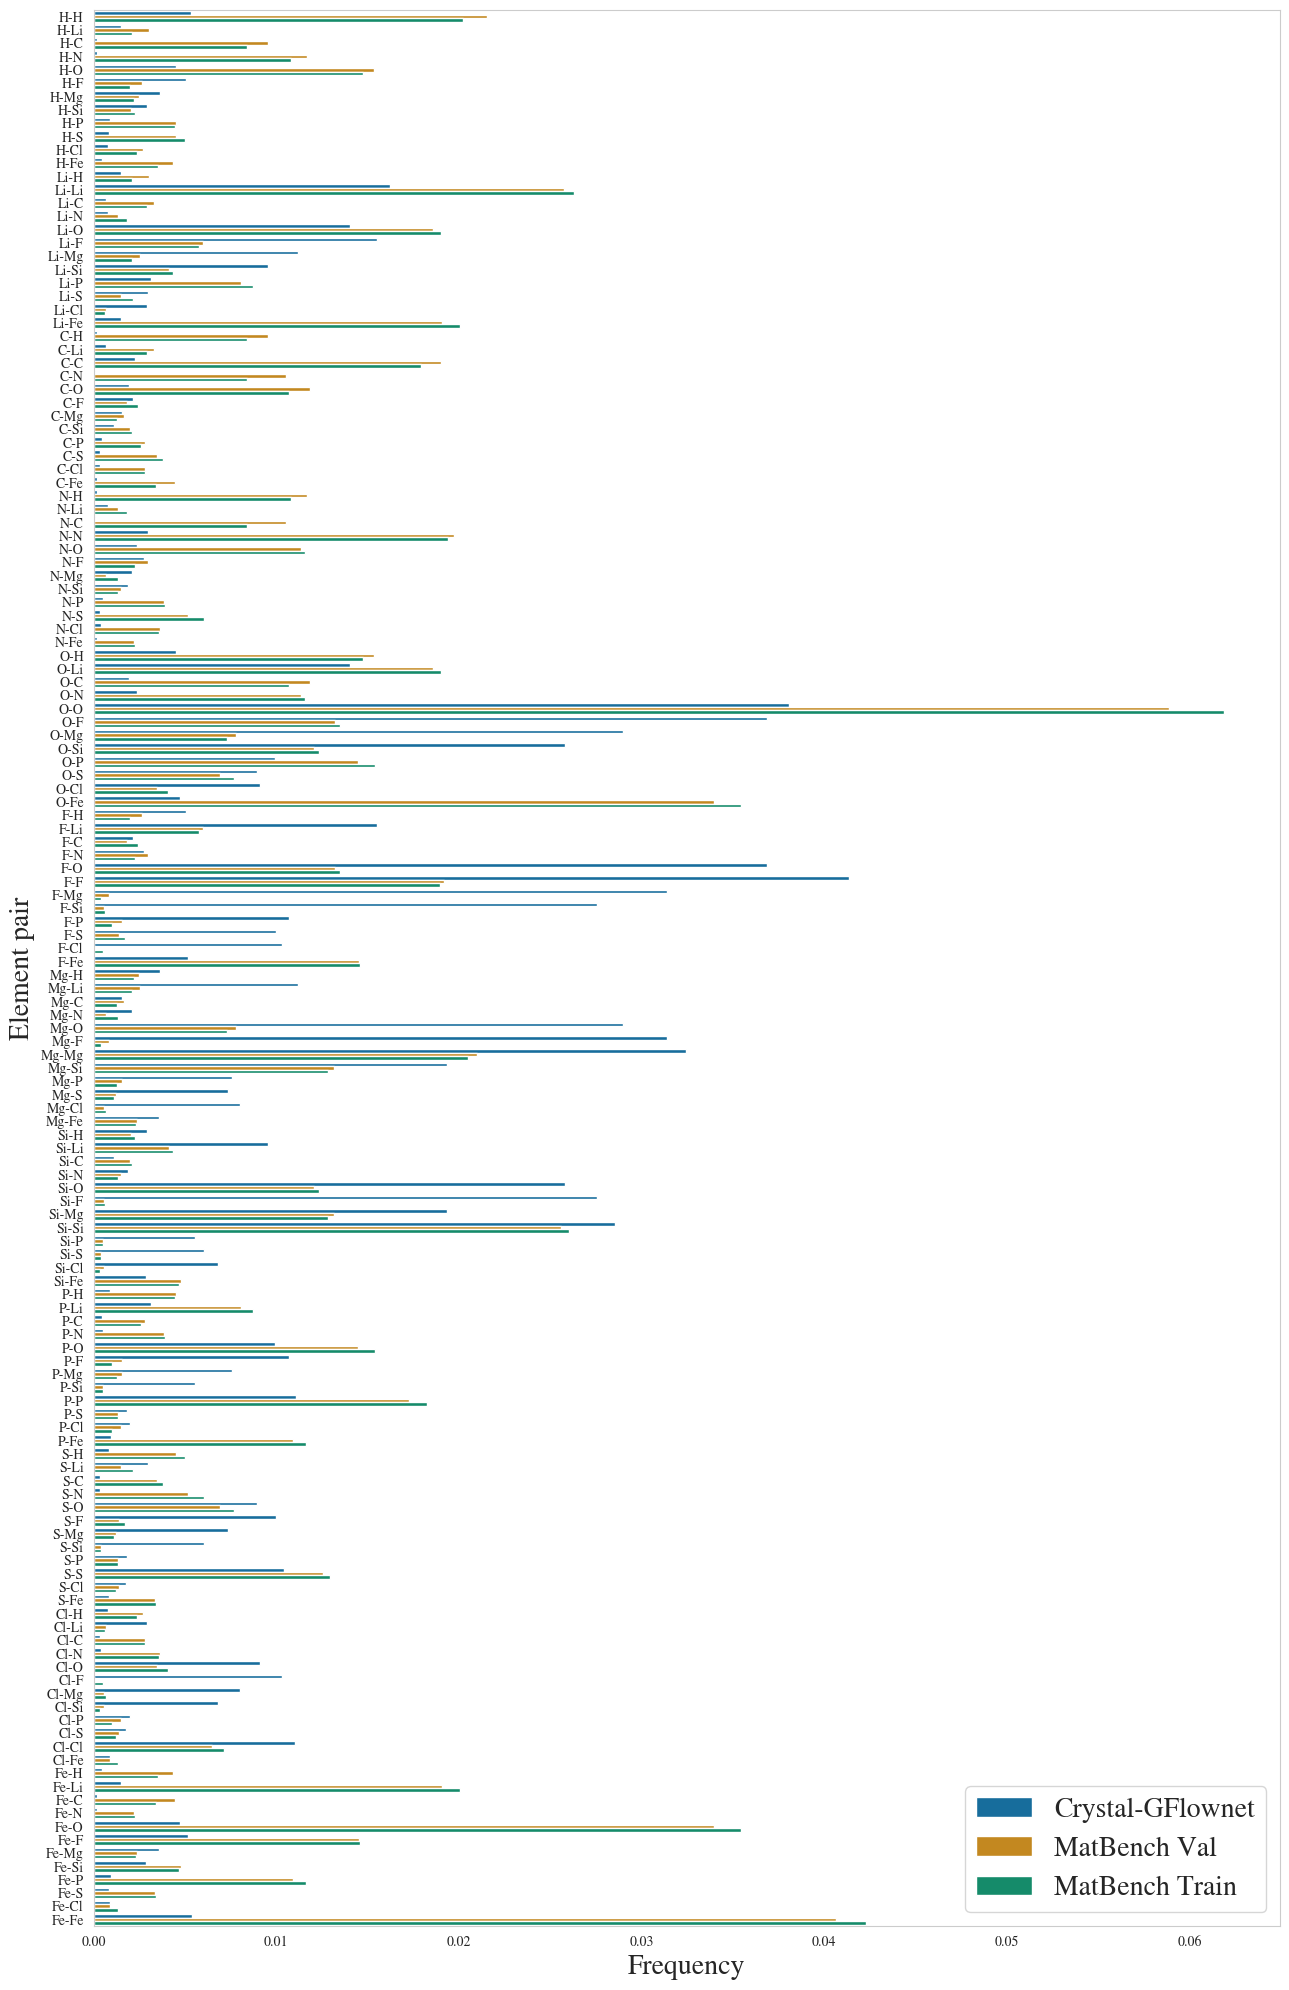

In [19]:
# plot the bar plot of the binarized element co-occurrences
# in the data versus the samples
# counts should be normalized by the total number of elements per data source

cooc_bin_counts_normed = []
for tmp_df in [sdf, v12df, t12df]:
    bin_df = (tmp_df[els] > 0).astype(int)
    cooc_df = bin_df.T.dot(bin_df)
    cooc_df = cooc_df / cooc_df.sum().sum()
    cooc_bin_counts_normed.append(cooc_df)

cooc_df = []
for t, tmp_df in enumerate(cooc_bin_counts_normed):
    for i in tmp_df.index:
        for j in tmp_df.columns:
            cooc_df.append(
                {
                    "pair": f"{i}-{j}",
                    "frequency": tmp_df.loc[i, j],
                    "source": ["Crystal-GFlownet", "MatBench Val", "MatBench Train"][t],
                }
            )
cooc_df = pd.DataFrame(cooc_df)

fig, ax = plt.subplots(figsize=(13, 20))
# horizontal bar plot
sns.barplot(data=cooc_df, y="pair", x="frequency", hue="source", ax=ax)
ax.set_xlabel("Frequency", fontdict={"size": 20})
ax.set_ylabel("Element pair", fontdict={"size": 20})
ax.set_yticklabels(cooc_df["pair"].unique())
fig.tight_layout()
ax.grid(False)
ax.legend(fontsize=20, loc="lower right")
fig.savefig(output_path / "el_cooc_counts.pdf")

/tmp/ipykernel_41730/432069784.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(denorm_yticks)
/tmp/ipykernel_41730/432069784.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(denorm_yticks)
/tmp/ipykernel_41730/432069784.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(denorm_yticks)
/tmp/ipykernel_41730/432069784.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(denorm_yticks)
/tmp/ipykernel_41730/432069784.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(denorm_yticks)
/tmp/ipykernel_41730/432069784.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(denorm_yticks)


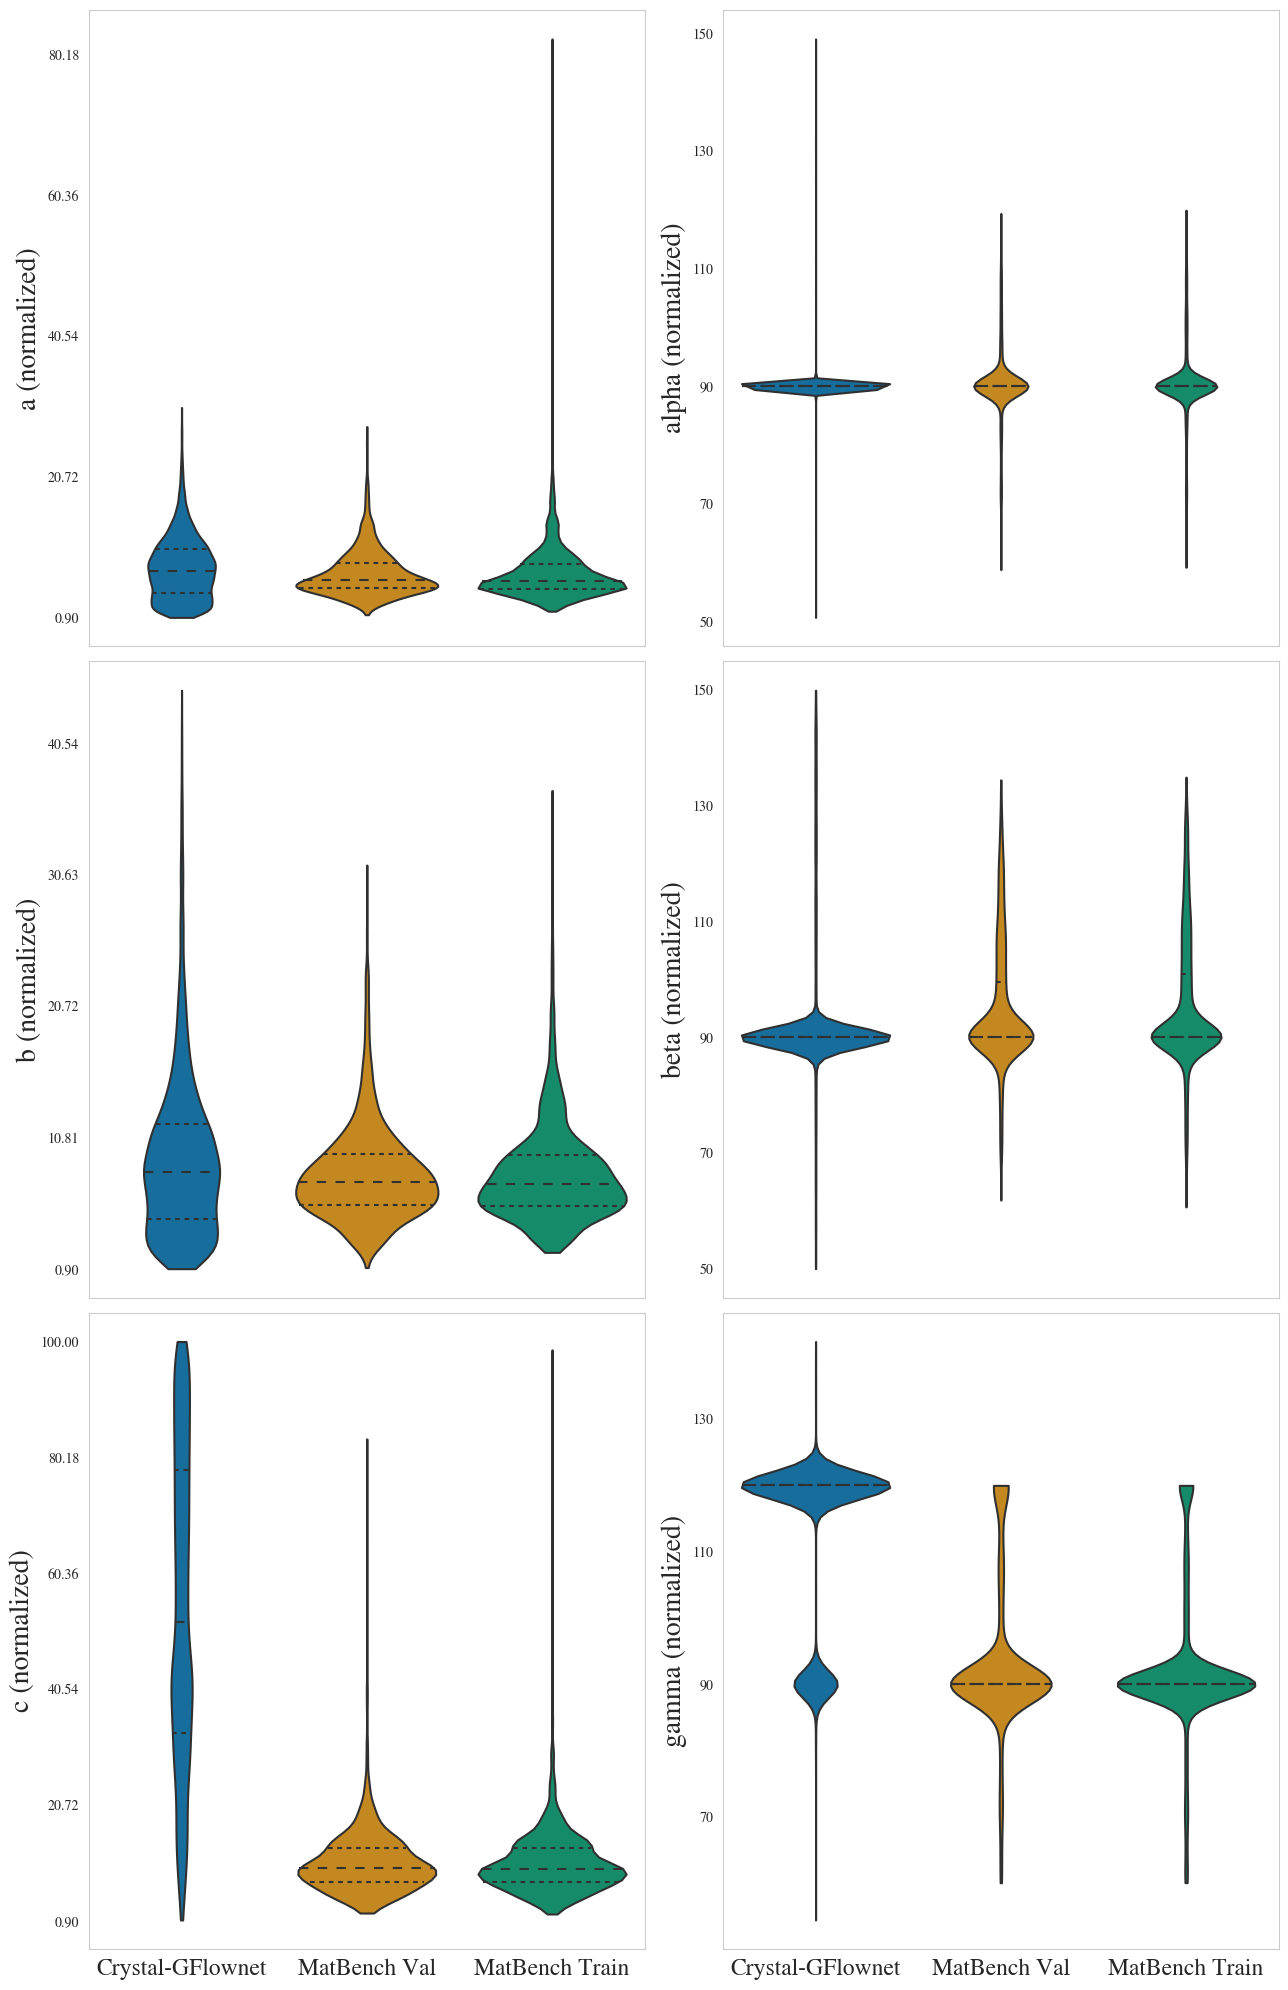

In [20]:
# plot the distribution of the lattice parameters
# in the data versus the samples
# each lattice parameter should be normalized by the range of the parameter
# in the training data
# the distribution should be plotted as a violin plot per lattice parameter

lattice_params = ["a", "b", "c", "alpha", "beta", "gamma"]
lattice_params_min = np.array([0.9, 0.9, 0.9, 50, 50, 50])
lattice_params_max = np.array([100, 100, 100, 150, 150, 150])

sdf_lattice_params = sdf[lattice_params]
valdf_lattice_params = v12df[lattice_params]
traindf_lattice_params = t12df[lattice_params]

sdf_lattice_params_normed = (sdf_lattice_params - lattice_params_min) / (
    lattice_params_max - lattice_params_min
)
valdf_lattice_params_normed = (valdf_lattice_params - lattice_params_min) / (
    lattice_params_max - lattice_params_min
)
traindf_lattice_params_normed = (traindf_lattice_params - lattice_params_min) / (
    lattice_params_max - lattice_params_min
)

lattice_params_normed = pd.concat(
    [
        sdf_lattice_params_normed,
        valdf_lattice_params_normed,
        traindf_lattice_params_normed,
    ]
)
lattice_params_normed.columns = [
    f"{c} (normalized)" for c in lattice_params_normed.columns
]
lattice_params_normed["source"] = sum(
    [
        [s] * c
        for s, c in zip(
            ["Crystal-GFlownet", "MatBench Val", "MatBench Train"],
            [len(sdf), len(v12df), len(t12df)],
        )
    ],
    [],
)

lattice_params_normed = lattice_params_normed.loc[lattice_params_normed["c (normalized)"] <= 1]

# plot the distribution of the lattice parameters as subplots:
# one subplot per lattice parameter
# one violin per data source
# the y-axis should be the normalized lattice parameter
# the x-axis should be the data source
# the x-axis should be labeled with the data source name
# the y-axis should be labeled with the lattice parameter name

fig, axes = plt.subplots(3, 2, figsize=(13, 20), sharey=False, sharex=True)

for i, p in enumerate(lattice_params):
    ax_i = [0, 2, 4, 1, 3, 5][i]
    ax = axes.flatten()[ax_i]
    sns.violinplot(
        data=lattice_params_normed,
        x="source",
        y=f"{p} (normalized)",
        ax=ax,
        cut=0,
        inner="quartile",
    )
    ax.set_ylabel(f"{p} (normalized)", fontdict={"size": 20})
    ax.set_xlabel("")
    # denormalize y ticks
    yticks = ax.get_yticks()
    denorm_yticks = [f"{denorm_l(y):.2f}" for y in yticks] if i < 3 else [f"{denorm_a(y):.0f}" for y in yticks]
    ax.set_yticklabels(denorm_yticks)
    if i >= 2:
        ax.set_xticklabels(["Crystal-GFlownet", "MatBench Val", "MatBench Train"], fontdict={"size": 17})
    ax.grid(False)
fig.tight_layout()
fig.savefig(output_path / "lattice_params.pdf")

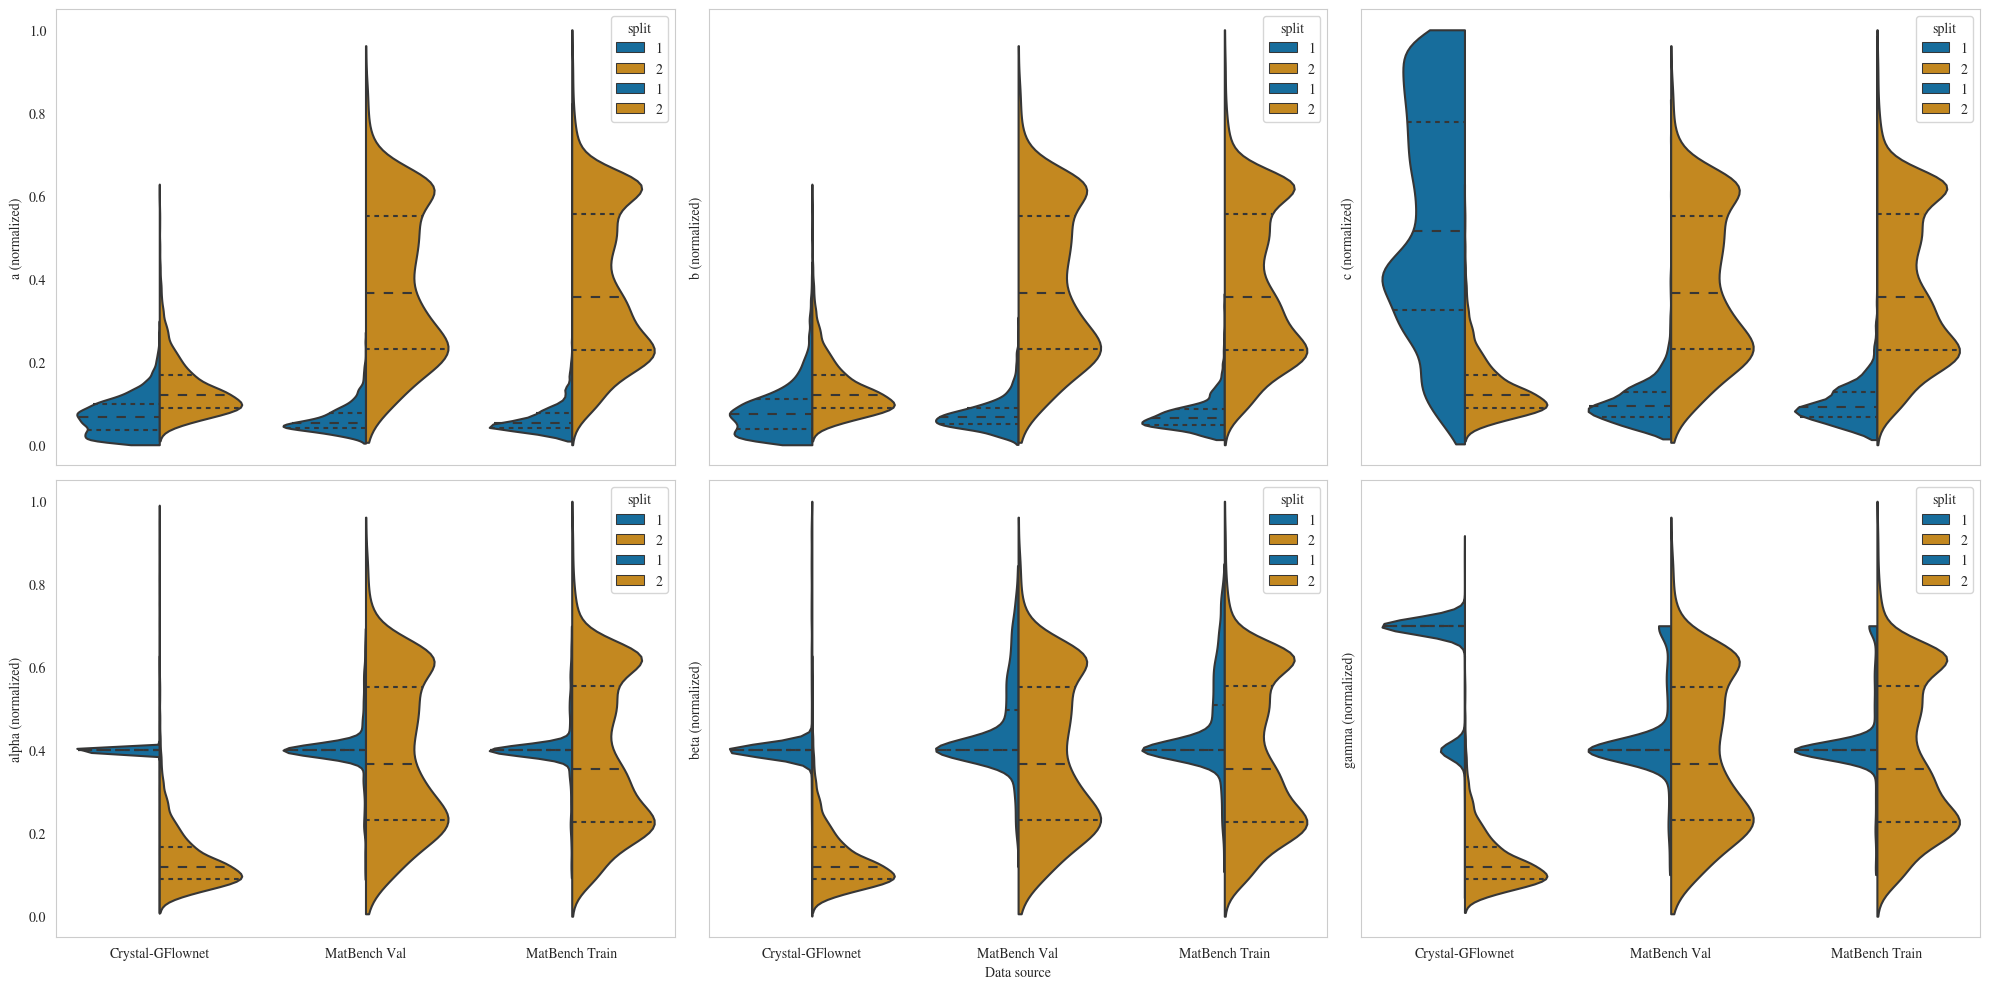

In [21]:
# plot the distribution of the lattice parameters
# in the data versus the samples
# each lattice parameter should be normalized by the range of the parameter
# in the training data
# the distribution should be plotted as a violin plot per lattice parameter

lattice_params = ["a", "b", "c", "alpha", "beta", "gamma"]
mins = np.array([0.9, 0.9, 0.9, 50, 50, 50])
maxs = np.array([100, 100, 100, 150, 150, 150])

sdf_lattice_params = sdf[lattice_params + ["energy"]]
valdf_lattice_params = v12df[lattice_params + ["energy"]]
traindf_lattice_params = t12df[lattice_params + ["energy"]]

lattice_params_df = pd.concat(
    [
        sdf_lattice_params,
        valdf_lattice_params,
        traindf_lattice_params,
    ]
)
mins = np.concatenate([mins, [lattice_params_df["energy"].min()]])
maxs = np.concatenate([maxs, [lattice_params_df["energy"].max()]])

lattice_params_df_normed = (lattice_params_df - mins) / (
    maxs - mins
)

lattice_params_df_normed.columns = [
    f"{c} (normalized)" for c in lattice_params_df_normed.columns
]
lattice_params_df_normed["source"] = sum(
    [
        [s] * c
        for s, c in zip(
            ["Crystal-GFlownet", "MatBench Val", "MatBench Train"],
            [len(sdf), len(v12df), len(t12df)],
        )
    ],
    [],
)

lattice_params_df_normed = lattice_params_df_normed.loc[lattice_params_df_normed["c (normalized)"] <= 1]
energy_normed = lattice_params_df_normed.copy()
lattice_params_df_normed["split"] = 1
dummy = lattice_params_df_normed.copy()
dummy[lattice_params_df_normed.columns] = np.nan
dummy["split"] = 2
lattice_params_df_normed = pd.concat([lattice_params_df_normed, dummy])

energy_normed["split"] = 2
dummy = energy_normed.copy()
dummy[energy_normed.columns] = np.nan
dummy["split"] = 1
energy_normed = pd.concat([energy_normed, dummy])


# plot the distribution of the lattice parameters as subplots:
# one subplot per lattice parameter
# one violin per data source
# the y-axis should be the normalized lattice parameter
# the x-axis should be the data source
# the x-axis should be labeled with the data source name
# the y-axis should be labeled with the lattice parameter name

fig, axes = plt.subplots(2, 3, figsize=(20, 10), sharey=True, sharex=True)

for i, p in enumerate(lattice_params):
    ax = axes.flatten()[i]
    sns.violinplot(
        data=lattice_params_df_normed,
        x="source",
        y=f"{p} (normalized)",
        ax=ax,
        cut=0,
        inner="quartile",
        split=True,
        hue="split"
    )
    sns.violinplot(
        data=energy_normed,
        x="source",
        y=f"energy (normalized)",
        ax=ax,
        cut=0,
        inner="quartile",
        split=True,
        hue="split"
    )
    ax.set_ylabel(f"{p} (normalized)")
    ax.set_xlabel("")
    if i >= 3:
        if i == 4:
            ax.set_xlabel("Data source")
        ax.set_xticklabels(["Crystal-GFlownet", "MatBench Val", "MatBench Train"])
    ax.grid(False)
fig.tight_layout()
fig.savefig(output_path / "lattice_params_split.pdf")

In [22]:
sns.color_palette("colorblind", 4)[3]

(0.8352941176470589, 0.3686274509803922, 0.0)

In [ ]:
def test_data_dict(data_dict, n_elements=12):
    # TEST
    index_stage = 0
    indices_composition = range(1, n_elements + 1)
    indices_sg = range(1 + n_elements, 1 + n_elements + 3)
    indices_lp = range(1 + n_elements + 3 + 1, 1 + n_elements + 3 + 6)

    x = np.array(data_dict["x"])

    stage = x[:, index_stage]
    comp = x[:, indices_composition]
    sg = x[:, indices_sg]
    lp = x[:, indices_lp]

    # Check stage is 2
    assert np.all(stage == 2)

    # Check SG number is nonzero
    assert np.all(sg[:, 2] != 0)
    # Check dummy values of SG are zero
    assert np.all(sg[:, :2] == 0)

    # Check LP are between zero and one
    assert np.all(lp >= 0.0)
    assert np.all(lp <= 1.0)

In [15]:
def df_row_to_normed_gfn_sample(row, els, sg_key="Space Group"):
    prefix = [2]
    angles = [norm_a(row["alpha"]), norm_a(row["beta"]), norm_a(row["gamma"])]
    lengths = [norm_l(row["a"]), norm_l(row["b"]), norm_l(row["c"])]
    sg = [0, 0, int(row[sg_key])]
    composition = [int(row[el]) for el in els]
    return prefix + composition + sg + lengths + angles

In [17]:
# careful: in this format, space group key is "sg" not "Space Group"
# energy key is "energy" not "Eform"
t_normed_12 = {"x": [], "energy": []}
skipped = []
for i, row in tqdm(t12df.iterrows(), total=len(t12df)):
    candidate = df_row_to_normed_gfn_sample(row, els, sg_key="sg")
    if any([c > 1 for c in candidate[-6:]]) or any([c < 0 for c in candidate[-6:]]):
        skipped.append(i)
        continue
    t_normed_12["x"].append(candidate)
    t_normed_12["energy"].append(row["energy"])
print(f"Skipped {len(skipped)} samples.")

 48%|████▊     | 1365/2861 [00:00<00:00, 13647.18it/s]

100%|██████████| 2861/2861 [00:00<00:00, 9698.29it/s] 

Skipped 4 samples.


In [18]:
t_normed_12_path = "/network/scratch/s/schmidtv/crystals-proxys/data/ai4mat-plots-data/matbench_normed_l0.9-100_a50-150_train_12_SGinter_states_energy.pkl"
# comment out for safety not to overwrite
test_data_dict(t_normed_12, n_elements=12)
with open(t_normed_12_path, "wb") as f:
    pickle.dump(t_normed_12, f)

In [19]:
# careful: in this format, space group key is "sg" not "Space Group"
# energy key is "energy" not "Eform"
v_normed_12 = {"x": [], "energy": []}
skipped = []
for i, row in tqdm(v12df.iterrows(), total=len(v12df)):
    candidate = df_row_to_normed_gfn_sample(row, els, sg_key="sg")
    if any([c > 1 for c in candidate[-6:]]) or any([c < 0 for c in candidate[-6:]]):
        skipped.append(i)
        continue
    v_normed_12["x"].append(candidate)
    v_normed_12["energy"].append(row["energy"])
print(f"Skipped {len(skipped)} samples.")

100%|██████████| 1118/1118 [00:00<00:00, 13920.13it/s]

Skipped 0 samples.


In [20]:
v_normed_12_path = "/network/scratch/s/schmidtv/crystals-proxys/data/ai4mat-plots-data/matbench_normed_l0.9-100_a50-150_val_12_SGinter_states_energy.pkl"
# comment out for safety not to overwrite
test_data_dict(v_normed_12, n_elements=12)
with open(v_normed_12_path, "wb") as f:
    pickle.dump(v_normed_12, f)

In [7]:
t_normed_84 = {"x": [], "energy": []}
skipped = []
for i, row in tqdm(full_train_df.iterrows(), total=len(full_train_df)):
    candidate = df_row_to_normed_gfn_sample(row, non_zero_els)
    if any([c > 1 for c in candidate[-6:]]) or any([c < 0 for c in candidate[-6:]]):
        skipped.append(i)
        continue
    t_normed_84["x"].append(candidate)
    t_normed_84["energy"].append(row["Eform"])
print(f"Skipped {len(skipped)} samples because of bounds")

  0%|          | 0/65048 [00:00<?, ?it/s]

100%|██████████| 65048/65048 [00:15<00:00, 4155.73it/s]

Skipped 53 samples because of bounds


In [8]:
t_normed_84_path = "/network/scratch/s/schmidtv/crystals-proxys/data/ai4mat-plots-data/matbench_normed_l0.9-100_a50-150_train_84_SGinter_states_energy.pkl"
test_data_dict(t_normed_84, n_elements=84)
with open(t_normed_84_path, "wb") as f:
    pickle.dump(t_normed_84, f)

In [9]:
v_normed_84 = {"x": [], "energy": []}
skipped = []
for i, row in tqdm(full_val_df.iterrows(), total=len(full_val_df)):
    candidate = df_row_to_normed_gfn_sample(row, non_zero_els)
    if any([c > 1 for c in candidate[-6:]]) or any([c < 0 for c in candidate[-6:]]):
        skipped.append(i)
        continue
    v_normed_84["x"].append(candidate)
    v_normed_84["energy"].append(row["Eform"])
print(f"Skipped {len(skipped)} samples because of bounds")

  0%|          | 0/23232 [00:00<?, ?it/s]

100%|██████████| 23232/23232 [00:05<00:00, 4135.10it/s]

Skipped 22 samples because of bounds


In [1]:
v_normed_84_path = "/network/scratch/s/schmidtv/crystals-proxys/data/ai4mat-plots-data/matbench_normed_l0.9-100_a50-150_val_84_SGinter_states_energy.pkl"
test_data_dict(v_normed_84, n_elements=84)
with open(v_normed_84_path, "wb") as f:
    pickle.dump(v_normed_84, f)

NameError: name 'pickle' is not defined

In [23]:
print(f'[{", ".join(map(str, sorted(full_train_df["Space Group"].unique())))}]')


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 208, 209, 210, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 2

In [40]:
all_els = np.array(full_train_df.columns[h_idx:e_idx])

In [51]:
reverse_mapping = {el: idx+1 for idx, el in table.to_dict().items()}

In [48]:

non_zero_els = all_els[full_train_df.values[:, h_idx:e_idx].sum(0) != 0]

In [57]:
full_train_z = [reverse_mapping[el] for el in non_zero_els]
print(full_train_z)

[1, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 89, 90, 91, 92, 93, 94]


count    65048.000000
mean         7.381630
std          3.575392
min          1.780871
25%          5.056292
50%          6.550443
75%          8.864103
max         82.429940
Name: a, dtype: float64
0
65040

count    65048.000000
mean         8.113886
std          3.882443
min          2.131537
25%          5.577596
50%          7.455519
75%          9.892388
max        137.342760
Name: b, dtype: float64
0
65039

count    65048.000000
mean        11.332843
std          8.084415
min          2.052674
25%          7.164834
50%          9.742468
75%         13.237583
max        302.225340
Name: c, dtype: float64
15
64724

count    65048.000000
mean        90.231778
std          4.859906
min         58.345417
25%         90.000000
50%         90.000000
75%         90.000000
max        121.787520
Name: alpha, dtype: float64
0
0

count    65048.000000
mean        94.085120
std         10.103467
min         60.028015
25%         90.000000
50%         90.000000
75%         91.563160
max      

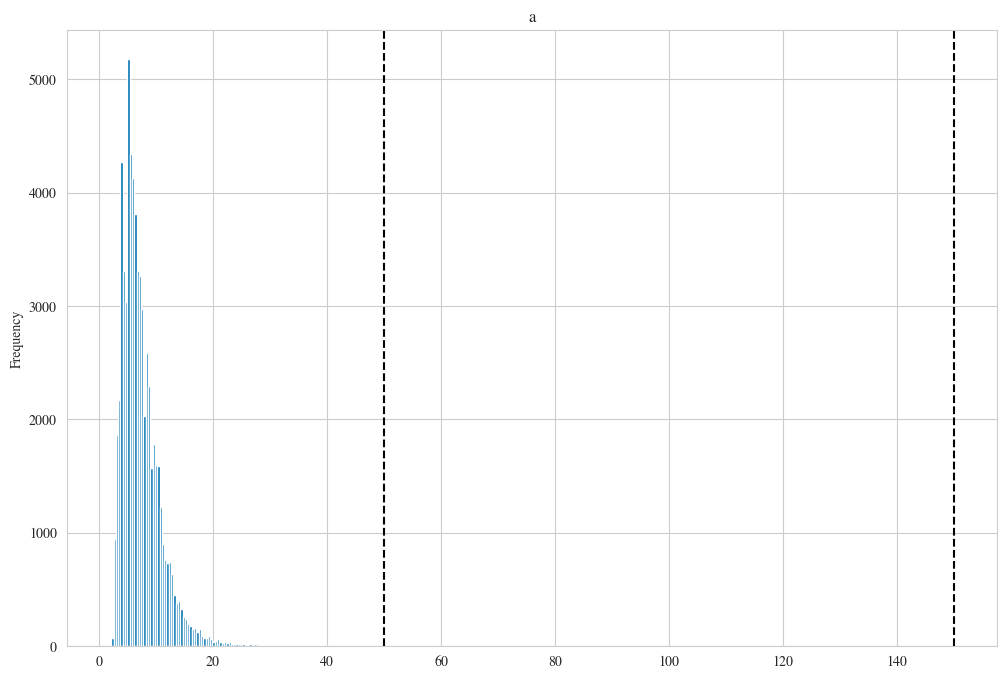

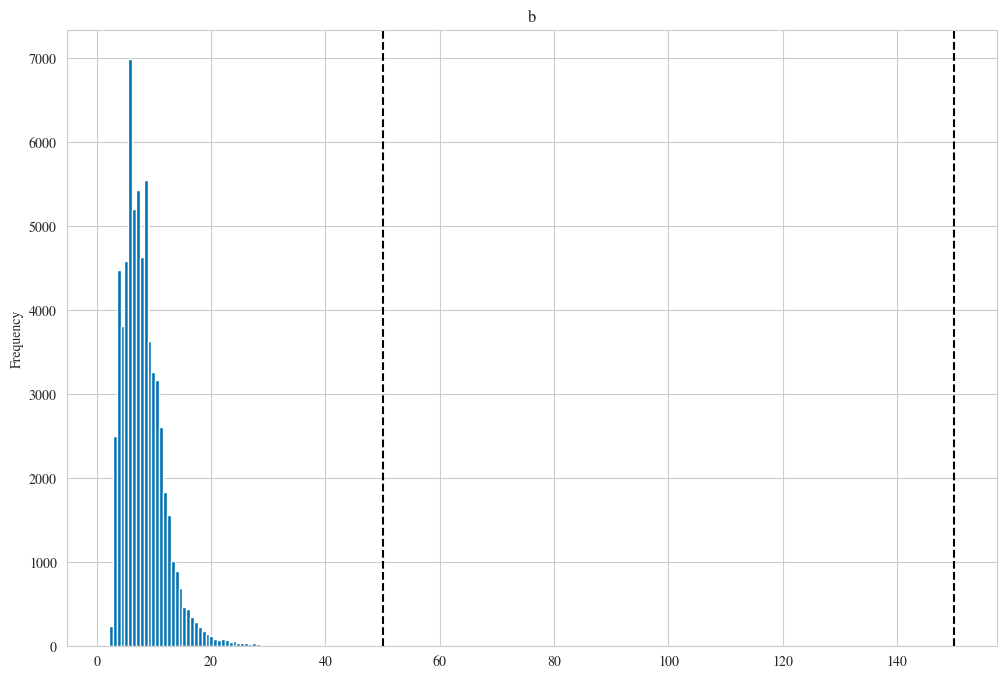

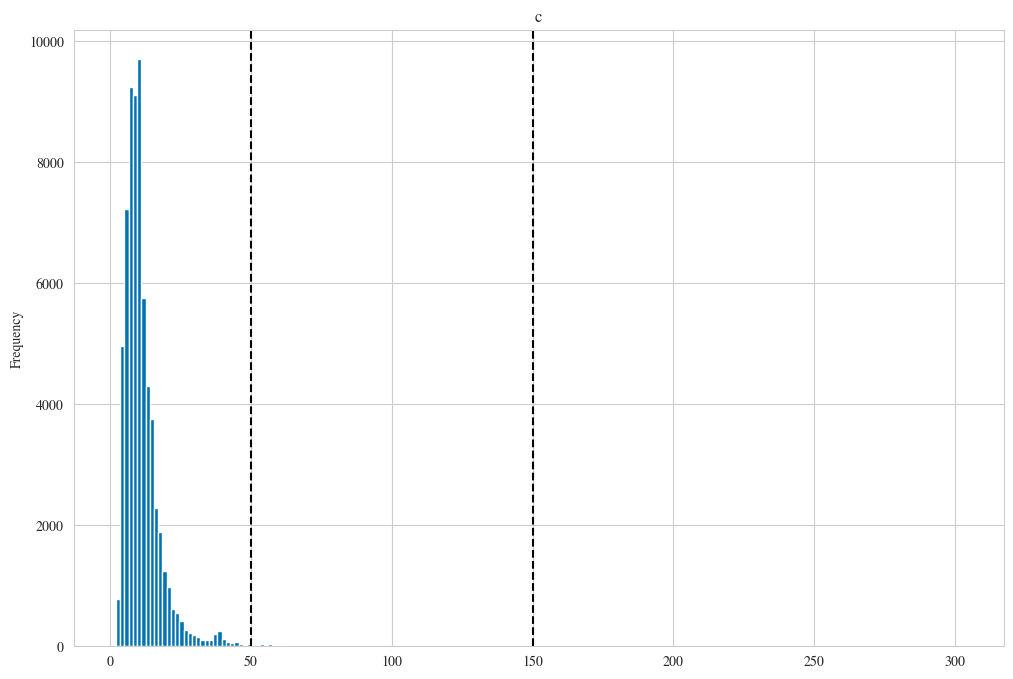

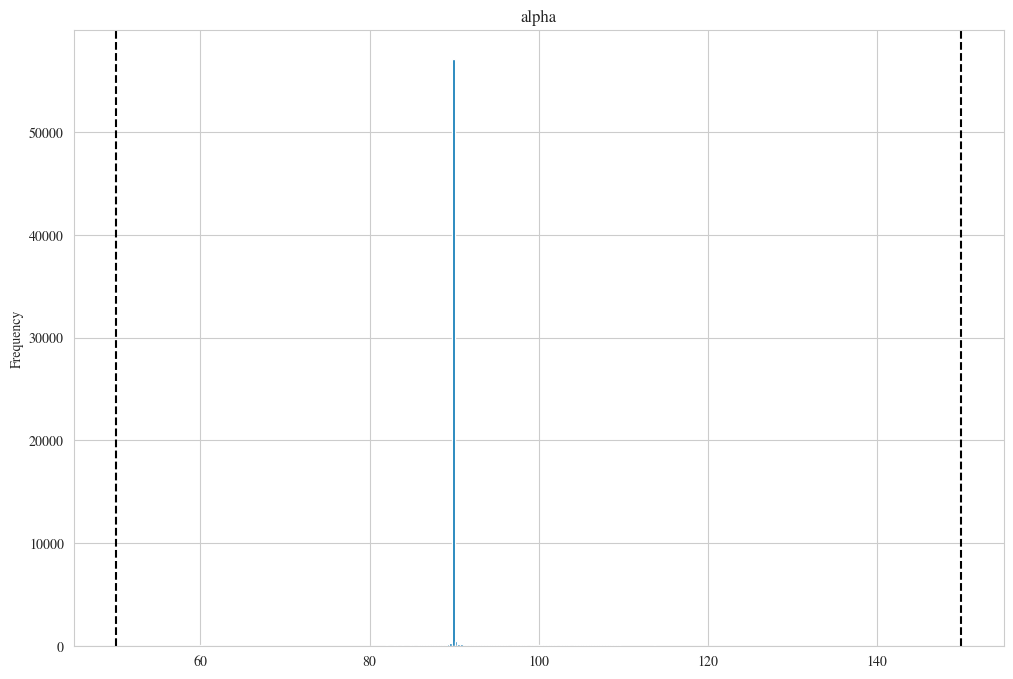

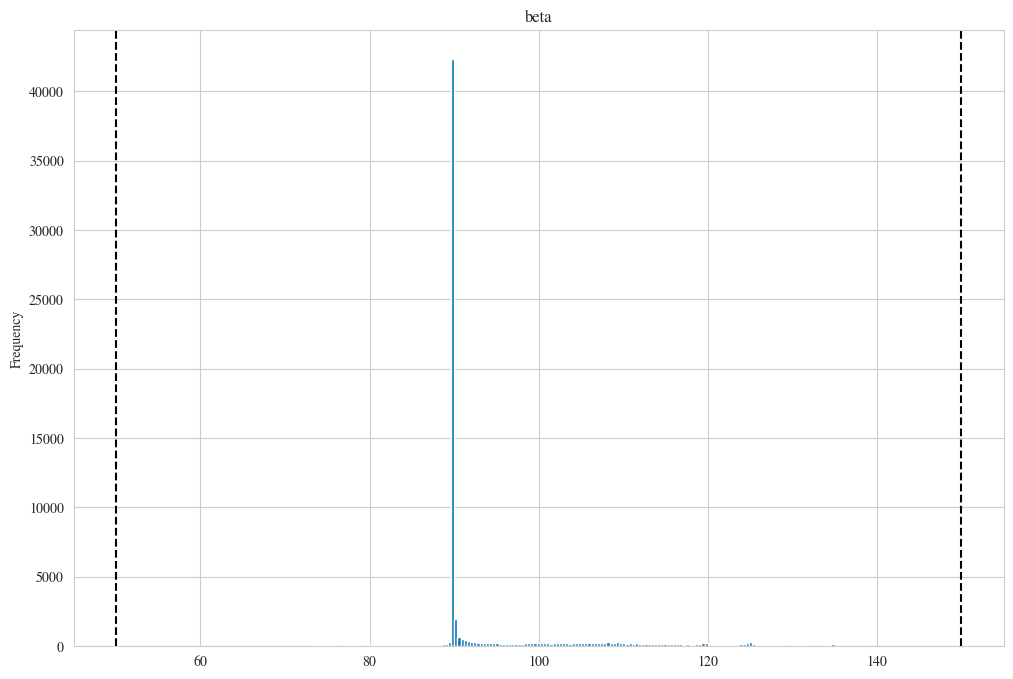

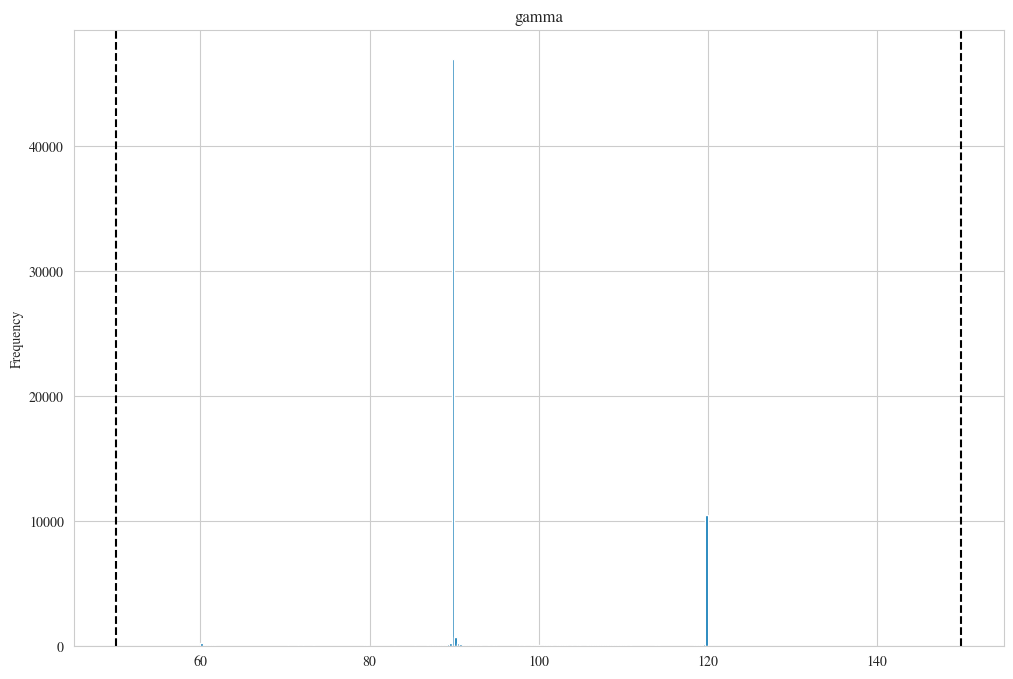

In [85]:
for col in ["a", "b", "c", "alpha", "beta", "gamma"]:
    plt.figure(figsize=(12, 8))
    full_train_df[col].plot.hist(bins=200)
    plt.axvline(150, color="black", linestyle="--")
    plt.axvline(50, color="black", linestyle="--")
    plt.title(col)
    print(full_train_df[col].describe())
    print((full_train_df[col] > 150).sum())
    print((full_train_df[col] < 50).sum())
    print()

In [78]:
cols = ["a", "b", "c", "alpha", "beta", "gamma"]
for col in cols:
    lower_bound = 0.9 if col in ["a", "b", "c"] else 50
    upper_bound = 100 if col in ["a", "b", "c"] else 150
    smaller = (full_train_df[col] < lower_bound).sum()
    larger = (full_train_df[col] > upper_bound).sum()
    print(f"{col}: {smaller} smaller, {larger} larger")

a: 0 smaller, 0 larger
b: 0 smaller, 4 larger
c: 0 smaller, 49 larger
alpha: 0 smaller, 0 larger
beta: 0 smaller, 0 larger
gamma: 0 smaller, 0 larger


In [79]:
cols = ["a", "b", "c", "alpha", "beta", "gamma"]
for col in cols:
    lower_bound = 0.9 if col in ["a", "b", "c"] else 50
    upper_bound = 100 if col in ["a", "b", "c"] else 150
    smaller = (full_val_df[col] < lower_bound).sum()
    larger = (full_val_df[col] > upper_bound).sum()
    print(f"{col}: {smaller} smaller, {larger} larger")

a: 0 smaller, 0 larger
b: 0 smaller, 0 larger
c: 0 smaller, 22 larger
alpha: 0 smaller, 0 larger
beta: 0 smaller, 0 larger
gamma: 0 smaller, 0 larger


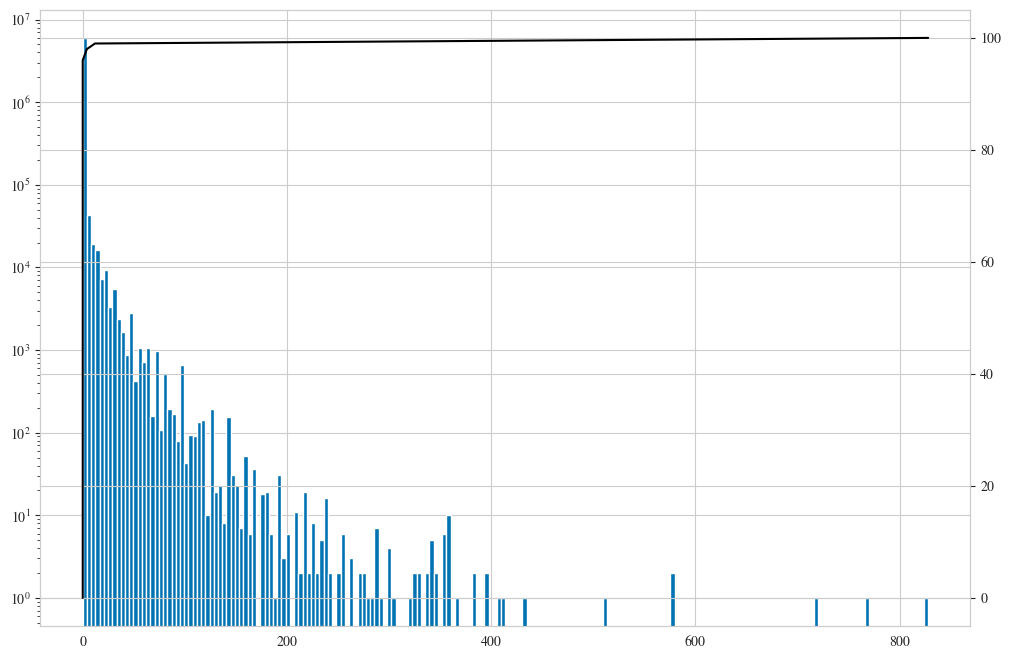

In [103]:
atom_counts = full_train_df[full_train_df.columns[h_idx:e_idx]].values.reshape(-1)
percs = np.percentile(atom_counts, range(0, 101))

plt.figure(figsize=(12, 8))
plt.hist(full_train_df[full_train_df.columns[h_idx:e_idx]].values.reshape(-1), bins=200)
plt.yscale("log")
ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(percs, range(0, 101), color="black")
# yscale log:

In [101]:
percs

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   4.,
        12., 828.])

array([ 13.,  14.,  14.,  14.,  14.,  14.,  16.,  16.,  16.,  16.,  16.,
        16.,  16.,  16.,  16.,  16.,  16.,  16.,  16.,  16.,  16.,  16.,
        16.,  16.,  16.,  16.,  16.,  16.,  16.,  18.,  18.,  18.,  18.,
        18.,  18.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  22.,  24.,
        24.,  24.,  24.,  24.,  24.,  24.,  24.,  24.,  24.,  24.,  24.,
        24.,  24.,  24.,  26.,  27.,  28.,  28.,  28.,  28.,  30.,  30.,
        32.,  32.,  32.,  32.,  32.,  32.,  32.,  32.,  36.,  36.,  36.,
        36.,  40.,  40.,  40.,  44.,  46.,  48.,  48.,  48.,  48.,  50.,
        54.,  56.,  58.,  64.,  64.,  72.,  72.,  80.,  84.,  96., 108.,
       132., 828.])

In [109]:
tedf = full_train_df[full_train_df.columns[h_idx:e_idx]]
(tedf > 0).sum(axis=1).value_counts()

3    30146
4    18267
2     9706
5     5537
6      944
1      339
7      101
8        6
9        2
Name: count, dtype: int64

In [110]:
vedf = full_val_df[full_val_df.columns[h_idx:e_idx]]
(vedf > 0).sum(axis=1).value_counts()

3    10881
4     6454
2     3385
5     1999
6      347
1      119
7       41
8        6
Name: count, dtype: int64

/tmp/ipykernel_7335/3711089687.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels([f"{x:.2f}" for x in axs[0].get_yticks()], fontsize=14)
/tmp/ipykernel_7335/3711089687.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels([f"{x:.2f}" for x in axs[1].get_yticks()], fontsize=14)
/tmp/ipykernel_7335/3711089687.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  axs[1].set_xticklabels([f"{x+1}  |  n={len(full_val_df[full_train_df['n_species'] == x+1])}" for x in axs[1].get_xticks()], fontsize=14, rotation=270)
/tmp/ipykernel_7335/3711089687.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  axs[1].set_xticklabels([f"{x+1}  |  n={len(full_val_df[full_train_df['n_species'] == x+1])}" for x in axs[1].get_xticks()], fontsize=14, rotation=270)
/tmp/ipykernel_7335/3711089687.py:17: UserWarning: Boolean Series key will be 

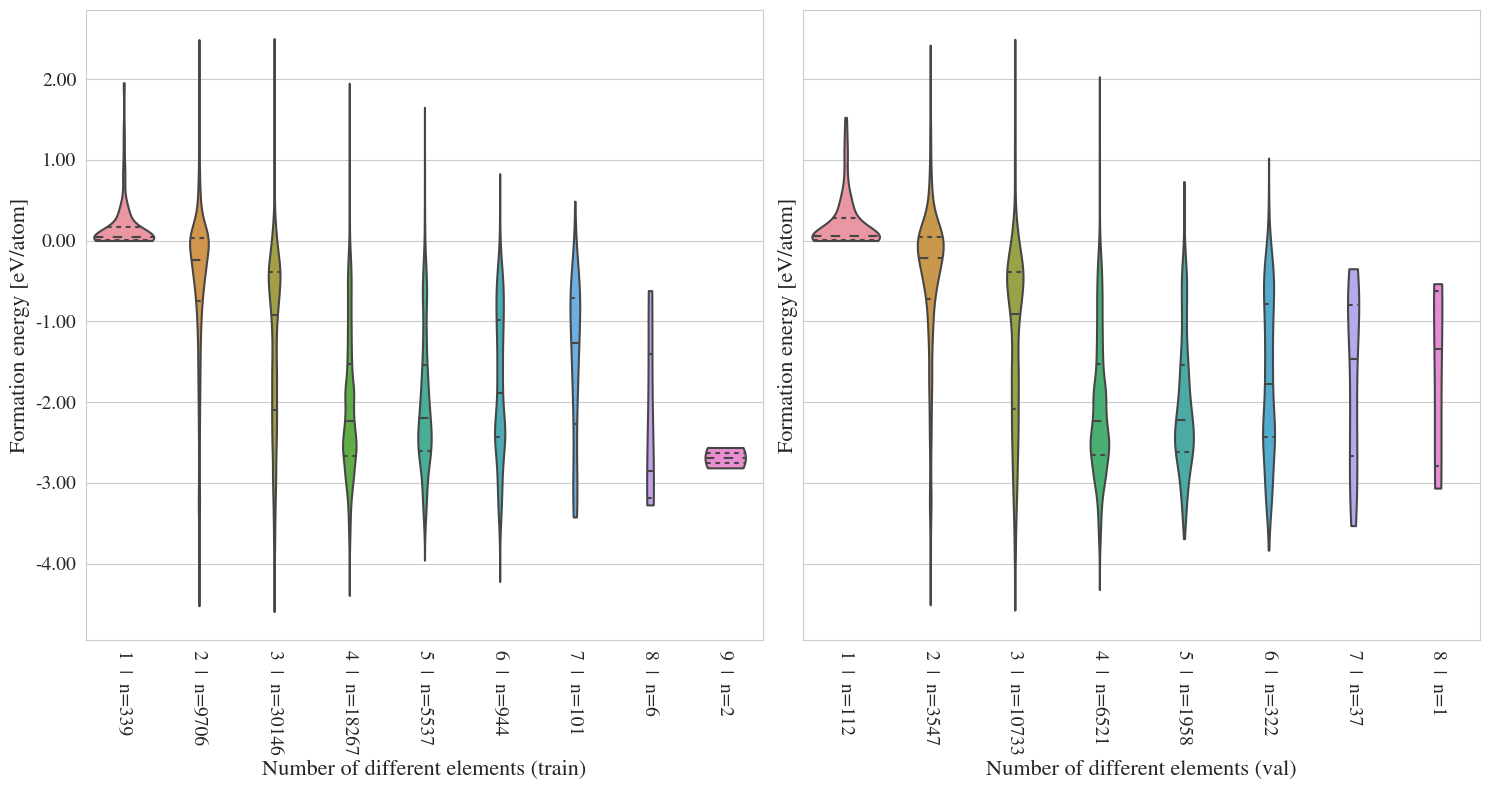

In [130]:
# plot the violin distribution of Eform per number of different atoms (=species) in the formula

full_train_df["n_species"] = (tedf > 0).sum(axis=1)
full_val_df["n_species"] = (vedf > 0).sum(axis=1)

fig, axs = plt.subplots(1, 2,figsize=(15, 8), sharey=True)
sns.violinplot(data=full_train_df, x="n_species", y="Eform", ax=axs[0], cut=0, inner="quartile")
axs[0].set_xlabel("Number of different elements (train)", fontsize=16)
axs[0].set_ylabel("Formation energy [eV/atom]", fontsize=16)
axs[0].set_yticklabels([f"{x:.2f}" for x in axs[0].get_yticks()], fontsize=14)
axs[0].set_xticklabels([f"{x+1}  |  n={len(full_train_df[full_train_df['n_species'] == x+1])}" for x in axs[0].get_xticks()], fontsize=14, rotation=270)

sns.violinplot(data=full_val_df, x="n_species", y="Eform", ax=axs[1], cut=0, inner="quartile")
axs[1].set_xlabel("Number of different elements (val)", fontsize=16)
axs[1].set_ylabel("Formation energy [eV/atom]", fontsize=16)
axs[1].set_yticklabels([f"{x:.2f}" for x in axs[1].get_yticks()], fontsize=14)
axs[1].set_xticklabels([f"{x+1}  |  n={len(full_val_df[full_train_df['n_species'] == x+1])}" for x in axs[1].get_xticks()], fontsize=14, rotation=270)

fig.tight_layout()
ax.grid(False)

In [124]:
axs[1].get_xticks()

array([0, 1, 2, 3, 4, 5, 6, 7])